## Revised Homework 2 : Cold k-means

In this element, I am attempting to group countries together using k-means, using exports, income, and GDP per capita to group them together. The k-means is my cold implementation. 

In [1]:
#importing packages
from scipy.spatial import distance  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#importing data
data = pd.read_csv("Country-data.csv", sep= ",")
data_NP = data.to_numpy()

data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
#creating the subset of variables I will use
data_subset = data[['exports','income','gdpp']]

#dropping rows with NaN values
data_subset = data_subset.dropna()
data_subset.head()


,exports,income,gdpp
0,10.0,1610,553
1,28.0,9930,4090
2,38.4,12900,4460
3,62.3,5900,3530
4,45.5,19100,12200


In [4]:
#turning subset into numpy array
data_subset_NP = data_subset.to_numpy()

In [5]:
#normalizing variables in data_subset_NP and creating subsets

exports = data_subset_NP[:,0]
mx = np.max(exports)
mn = np.min(exports)

exports_norm = (exports - mn)/(mx - mn)
exports_norm = np.around(exports_norm, decimals = 2) 

income = data_subset_NP[:,1]
mx = np.max(income)
mn = np.min(income)

income_norm = (income - mn)/(mx - mn)
income_norm = np.around(income_norm, decimals = 2) 

gdpp = data_subset_NP[:,2]
mx = np.max(gdpp)
mn = np.min(gdpp)

gdpp_norm = (gdpp - mn)/(mx - mn)
gdpp_norm = np.around(gdpp_norm, decimals = 2) 

# these are all variables against each other
exports_vs_income_vs_gdpp = np.stack((exports_norm, income_norm,gdpp_norm),axis=-1)

# just exports and GDP per capita
exports_vs_gdpp = np.stack((exports_norm, gdpp_norm),axis=-1)

# just income and GDP per capita
income_vs_gdpp = np.stack((income_norm, gdpp_norm),axis=-1)


In [6]:
# My cold kmeans implementation, which takes in the array, the number of clusters, and a random state
# and outputs the cluster centers, as well as the cluster to which each point belongs to

def cold_kmeans(arrayName, k, randomState):
    df = pd.DataFrame(arrayName)
    
    #finding k centers 
    centers= df.sample(k, random_state = randomState)
    centers_np = centers.to_numpy()

    #oldCenters, used for storing the centers of the current iteration, is initialized
    oldCenters = []

    # The centers are recalculated until the centers from the new calculations are equal to the centers 
    # from the previous calculation. Therefore, the stopping condition is when the clusters stop 
    # changing and all centers remain the same. 
    
    # To avoid falling into a local minima, a second stopping condition is used: number of iterations
    i = 0
    
    while (not (np.array_equal(oldCenters, centers_np)) and i<300):
        #iteration number increased
        i+=1
        
        #old Centers are set to whatever centers were calculated before 
        oldCenters = np.copy(centers_np)
        
        #new distances calculated and clusters are assigned
        dists = distance.cdist(arrayName, centers_np, 'euclidean')
        clusters = np.argmin(dists, axis=1)

        #looping over each cluster
        for n in range (len(centers_np)):
            subset = []
            
            #adding the indices of the points in each cluster
            for i in range (len(clusters)):
                if (clusters[i]==n):
                    subset.append(i)
                    
            #taking a subset of the points in the cluster
            sub = df.iloc[subset]
            
            #finding a new center for this cluster and changing its value in centers_np
            centers_np[n] = sub.mean(axis=0)
    
    return centers_np, clusters


In [7]:
# This function repeatedly runs my kmeans algorithm with different values of k to determine which number
# of clusters is ideal.

def looping_kmeans(arrayName,kList):

    output = []

    for k in kList:
        within_cluster_sumsqs = 0
        
        output_of_kmeans = cold_kmeans(arrayName, k, 10)
        
        centers = output_of_kmeans[0]

        for c in range(0,k):
            # Extract the cluster's center and associated points:
            cluster_center = [centers[c,:]]
            cluster_points = arrayName[np.where(output_of_kmeans[1] == c)]
            
            # Compute the following for each cluster:
            cluster_spread = distance.cdist(cluster_points, cluster_center, 'euclidean')
            cluster_total = np.sum(cluster_spread)
            
            # Add this cluster's within sum of squares to within_cluster_sumsqs
            within_cluster_sumsqs = within_cluster_sumsqs + cluster_total
        
        output.append(within_cluster_sumsqs)
    
    return output

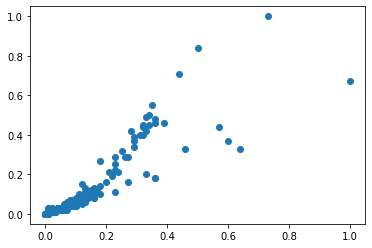

In [8]:
# A visualization of income vs GDP per capita
plt.scatter(x=income_vs_gdpp[:,0],y=income_vs_gdpp[:,1])

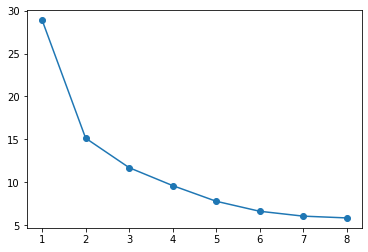

In [9]:
# Determining ideal number of clusters for income vs GDP per capita 

income_vs_gdpp_cluster_number = looping_kmeans(income_vs_gdpp,[1,2,3,4,5,6,7,8])

plt.plot(range(1,9),income_vs_gdpp_cluster_number,marker='o')
plt.show()

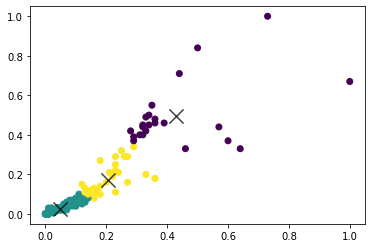

In [10]:
# There is an unclear elbow, but visually I think the idea number of clusters is 3
# To show the centers, I run my kmeans and plot the centers

income_vs_gdpp_output = cold_kmeans(income_vs_gdpp, 3, 1)
plt.scatter(x=income_vs_gdpp[:,0],y=income_vs_gdpp[:,1],c=income_vs_gdpp_output[1])
plt.scatter(income_vs_gdpp_output[0][:, 0], income_vs_gdpp_output[0][:, 1], c='black', marker="x", s=200, alpha=0.75)

In [11]:
# A list of all the countries in each group

print("The first group of countries is:")
for i in data_NP[np.where(income_vs_gdpp_output[1] == 0),0]:
    for x in i:
        print(x,end=", ")
print("\n")

print("The second group of countries is:")
for i in data_NP[np.where(income_vs_gdpp_output[1] == 1),0]:
    for x in i:
        print(x,end=", ")
print("\n")

print("The third group of countries is:")
for i in data_NP[np.where(income_vs_gdpp_output[1] == 2),0]:
    for x in i:
        print(x,end=", ")
print("\n")



The first group of countries is:
Australia, Austria, Belgium, Brunei, Canada, Denmark, Finland, France, Germany, Iceland, Ireland, Japan, Kuwait, Luxembourg, Netherlands, Norway, Qatar, Singapore, Sweden, Switzerland, United Arab Emirates, United Kingdom, United States, 

The second group of countries is:
Afghanistan, Albania, Algeria, Angola, Armenia, Azerbaijan, Bangladesh, Belarus, Belize, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Central African Republic, Chad, China, Colombia, Comoros, Congo, Dem. Rep., Congo, Rep., Costa Rica, Cote d'Ivoire, Dominican Republic, Ecuador, Egypt, El Salvador, Eritrea, Fiji, Gabon, Gambia, Georgia, Ghana, Grenada, Guatemala, Guinea, Guinea-Bissau, Guyana, Haiti, India, Indonesia, Iran, Iraq, Jamaica, Jordan, Kenya, Kiribati, Kyrgyz Republic, Lao, Lebanon, Lesotho, Liberia, Macedonia, FYR, Madagascar, Malawi, Maldives, Mali, Mauritania, Mauritius, Micronesia, Fed.

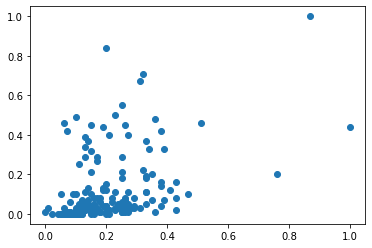

In [12]:
# A visualization of exports vs GDP per capita
plt.scatter(x=exports_vs_gdpp[:,0],y=exports_vs_gdpp[:,1])

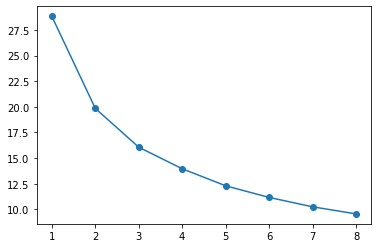

In [13]:
# Determining ideal number of clusters for exports vs GDP per capita

exports_vs_gdpp_cluster_number = looping_kmeans(exports_vs_gdpp,[1,2,3,4,5,6,7,8])

plt.plot(range(1,9),exports_vs_gdpp_cluster_number,marker='o')
plt.show()

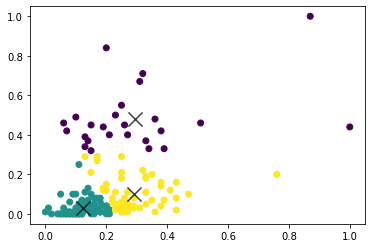

In [14]:
# There is another unclear elbow, but visually I think the idea number of clusters is 3
# To show the centers, I run my kmeans and plot the centers

exports_vs_gdpp_output = cold_kmeans(exports_vs_gdpp, 3, 1)
plt.scatter(x=exports_vs_gdpp[:,0],y=exports_vs_gdpp[:,1],c=exports_vs_gdpp_output[1])
plt.scatter(exports_vs_gdpp_output[0][:, 0], exports_vs_gdpp_output[0][:, 1], c='black', marker="x", s=200, alpha=0.75)

In [15]:
# A list of all the countries in each group

print("The first group of countries is:")
for i in data_NP[np.where(exports_vs_gdpp_output[1] == 0),0]:
    for x in i:
        print(x,end=", ")
print("\n")

print("The second group of countries is:")
for i in data_NP[np.where(exports_vs_gdpp_output[1] == 1),0]:
    for x in i:
        print(x,end=", ")
print("\n")

print("The third group of countries is:")
for i in data_NP[np.where(exports_vs_gdpp_output[1] == 2),0]:
    for x in i:
        print(x,end=", ")
print("\n")

The first group of countries is:
Australia, Austria, Belgium, Brunei, Canada, Denmark, Finland, France, Germany, Iceland, Ireland, Italy, Japan, Kuwait, Luxembourg, Netherlands, New Zealand, Norway, Qatar, Singapore, Sweden, Switzerland, United Arab Emirates, United Kingdom, United States, 

The second group of countries is:
Afghanistan, Albania, Algeria, Argentina, Armenia, Bangladesh, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Brazil, Burkina Faso, Burundi, Cameroon, Cape Verde, Central African Republic, Chad, China, Colombia, Comoros, Congo, Dem. Rep., Costa Rica, Dominican Republic, Ecuador, Egypt, El Salvador, Eritrea, Gambia, Georgia, Ghana, Greece, Grenada, Guatemala, Guinea, Guinea-Bissau, Haiti, India, Indonesia, Iran, Iraq, Jamaica, Kenya, Kiribati, Lao, Lebanon, Lesotho, Liberia, Macedonia, FYR, Madagascar, Malawi, Mali, Micronesia, Fed. Sts., Moldova, Montenegro, Morocco, Mozambique, Myanmar, Nepal, Niger, Nigeria, Pakistan, Peru, Philippines, Romania, Russia, Rwanda, 

In [88]:
# Include the 3 dimensional visualization

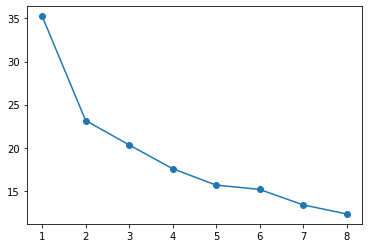

In [16]:
# Determining ideal number of clusters for all variables

exports_vs_income_vs_gdpp_cluster_number = looping_kmeans(exports_vs_income_vs_gdpp,[1,2,3,4,5,6,7,8])

plt.plot(range(1,9),exports_vs_income_vs_gdpp_cluster_number,marker='o')
plt.show()

In [17]:
# There is another unclear elbow, but visually I think the idea number of clusters is 3
# No visualization since there are 4 variables

all_variables_output = cold_kmeans(exports_vs_income_vs_gdpp, 3, 1)

# A list of all the countries in each group

print("The first group of countries is:")
for i in data_NP[np.where(all_variables_output[1] == 0),0]:
    for x in i:
        print(x,end=", ")
print("\n")

print("The second group of countries is:")
for i in data_NP[np.where(all_variables_output[1] == 1),0]:
    for x in i:
        print(x,end=", ")
print("\n")

print("The third group of countries is:")
for i in data_NP[np.where(all_variables_output[1] == 2),0]:
    for x in i:
        print(x,end=", ")
print("\n")




The first group of countries is:
Australia, Austria, Belgium, Brunei, Canada, Denmark, Finland, France, Germany, Iceland, Ireland, Italy, Japan, Kuwait, Luxembourg, Netherlands, Norway, Qatar, Singapore, Sweden, Switzerland, United Arab Emirates, United Kingdom, United States, 

The second group of countries is:
Afghanistan, Albania, Algeria, Angola, Argentina, Armenia, Bangladesh, Belize, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Central African Republic, Chad, China, Colombia, Comoros, Congo, Dem. Rep., Costa Rica, Cote d'Ivoire, Dominican Republic, Ecuador, Egypt, El Salvador, Eritrea, Fiji, Gambia, Georgia, Ghana, Grenada, Guatemala, Guinea, Guinea-Bissau, Guyana, Haiti, India, Indonesia, Iran, Iraq, Jamaica, Jordan, Kenya, Kiribati, Kyrgyz Republic, Lao, Lebanon, Lesotho, Liberia, Macedonia, FYR, Madagascar, Malawi, Mali, Mauritania, Micronesia, Fed. Sts., Moldova, Mongolia, Montenegro, Morocco, Mozambi

In [ ]:
# Talk about kmeans implementation, in terms of time and epochs

In [ ]:
# compare my kmeans to sklearn implementation

In [ ]:
# talk about how kmeans can only be used on numerical continuous data since "distance" needs to be computed 

Question 1: Your k-means implementation
For this question, you will submit your "cold" k-means implementation and include your justification for the stopping condition(s) that you used in your implementations. Your implementation should be called my_kmeans() and should set at three inputs in this order -

A numpy array
The number of cluster (ie. k)
The random_state
Your implementation should terminate with output including:

The cluster centers
Cluster labels for the data points
Question 2: Choosing k using elbowology
Part A
In k-means, we supply the number of clusters that we believe our data has. This means that the choice of k is made without being directly derived from the data. In this question, you will use elbowology to determine the number of clusters that our data falls into.

For this question, we will use the students_info.csv for this question. For each of the three variable combinations, please normalize your variables and then do the following:

Using either within cluster sum of squares or average cluster cohesion as the measure of cluster "goodness", write a function looping_kmeans that perform k-means using sklearn and computes the "goodness" of clusters for k=1, k=2, ..., k=10. While the k-means should use the sklearn implementation, the measure of "goodness" should be written by you. The inputs should be 1) a numpy array and list of values for k, with the output being the list of the "goodness" measures.
Plot the values of k against your chosen measure of cluster "goodness" as a line plot with each point marked clearly.
Examining your plot, find the value of k that is closest to the "elbow"; that is where the plot changes directions most sharply. This point should look like the elbow on a bent arm.
The variable combinations are:

Gym time and average cups of coffee
Sleep and GPA
All numerical variables within students_info.csv
Part B
Given your plots above, how many clusters do our students fall into. You must choose one number and justify your choice.

Question 3: Limitations of k-means
When working with a new method, we need to explore its limitations. For this question, we explore if k-means can work on all data. Considering three kinds of data, please explain if k-means can work on it. If you believe that it can, explain; and if not, offer a counter example.

Numerical variables: data that is just numbers, such as human height or outdoor temperature
Categorical variables: data that is based on categories or classes, such as coffee/tea preferences or favorite color
Ordinal variables: data that is categorical with an agreed upon ordering such as birth month or seasons
For each type, would k-means work? If yes, explain why. If not, provide a counter example.